In [1]:
#0_Imports_This script loads Airbnb datasets (listings, calendar, reviews), cleans them, builds a master dataset,
#computes city-level supply/demand/revenue proxies, then performs a San Sebastián spatial proxy analysis
#using latitude/longitude medians and generates a heatmap (Folium).

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Folium is used to generate an interactive HTML heatmap. If it is not installed, the script will skip that part gracefully.
try:
    import folium
    from folium.plugins import HeatMap
    FOLIUM_AVAILABLE = True
except ImportError:
    FOLIUM_AVAILABLE = False


In [2]:
#1_Load datasets 
#load the three core Airbnb datasets: listings, calendar, and reviews.
LISTINGS_PATH = "listings.csv.gz"
CALENDAR_PATH = "calendar.csv.gz"
REVIEWS_PATH = "reviews.csv.gz"

listings = pd.read_csv(LISTINGS_PATH)
calendar = pd.read_csv(CALENDAR_PATH)
reviews = pd.read_csv(REVIEWS_PATH)

In [3]:
#2_1__Data Familiarization :"listings"
listings.head(4)



,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,132068,https://www.airbnb.com/rooms/132068,20250628051911,2025-06-28,city scrape,Great attic+terrace+parking. Beach views. ESS0...,"Amazing modern, clean & fully equiped flat of...",Gros is the trendy neighborhood of Donosti. Th...,https://a0.muscache.com/pictures/hosting/Hosti...,648938,...,4.97,4.94,4.76,NaN,t,1,1,0,0,4.68
1,142760,https://www.airbnb.com/rooms/142760,20250628051911,2025-06-28,city scrape,Piso en la playa cerca de Gaztelugatxe,Beach front apartment close to San Juan de Gaz...,NaN,https://a0.muscache.com/pictures/71900ac6-da9b...,693119,...,4.64,4.70,4.71,NaN,t,1,1,0,0,0.49
2,225692,https://www.airbnb.com/rooms/225692,20250628051911,2025-06-29,city scrape,"Parte Vieja, San Sebastian",NaN,NaN,https://a0.muscache.com/pictures/31866298/de9d...,1176053,...,4.93,4.96,4.76,ESS00994,f,1,1,0,0,1.70
3,309812,https://www.airbnb.com/rooms/309812,20250628051911,2025-06-29,city scrape,Impresionante vivienda céntrica con vistas al mar,NaN,The apartment is located in the Romantic Area ...,https://a0.muscache.com/pictures/50826406/0c15...,1589633,...,4.92,4.92,4.62,NaN,f,6,5,1,0,0.09


In [4]:
#2_2_Data Familiarization "calendar"
calendar.head(100)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,9150482,2025-06-28,t,NaN,NaN,1,1125
1,9150482,2025-06-29,t,NaN,NaN,1,1125
2,9150482,2025-06-30,t,NaN,NaN,1,1125
3,9150482,2025-07-01,t,NaN,NaN,1,1125
4,9150482,2025-07-02,t,NaN,NaN,1,1125
...,...,...,...,...,...,...,...
95,9150482,2025-10-01,f,NaN,NaN,1,1125
96,9150482,2025-10-02,f,NaN,NaN,1,1125
97,9150482,2025-10-03,f,NaN,NaN,1,1125
98,9150482,2025-10-04,f,NaN,NaN,1,1125


In [5]:
#2_3_Data Familiarization "reviews"
reviews.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,132068,297597,2011-06-04,182987,Irina,"Mikel's place was outrageous, a perfect combin..."
1,132068,12519461,2014-05-04,5175212,Philippine & Grégoire,Mikel appartment is exactly as it is described...
2,132068,12600130,2014-05-05,2789268,Alvaro,La experiencia en el apartamento de Mikel fue ...
3,132068,13253988,2014-05-23,298828,Mayte,"Mikel Es una persona amable, el aspartamento e..."
4,132068,13294951,2014-05-24,7736822,Kaela,Absolutely wonderful apartment. Mikel was very...
5,132068,13584479,2014-05-31,1733869,Erik,My girlfriend and I had a great experience ren...
6,132068,13983118,2014-06-09,4766585,Amar,Mikel's apt was better than the pictures. The...
7,132068,14474810,2014-06-20,4988675,Signe,What a fantastic place! Mikel was really nice ...
8,132068,14745563,2014-06-25,618028,Clare,Wow what a fantastic stay! Mikel and his girlf...
9,132068,15177241,2014-07-04,2583587,Valérie,"Très bel appartement, spacieux et conforme aux..."


In [6]:
#2_1_ LISTINGS: Data familiarization, there are some outlier (bath=25, bed=25) I have to clean it in the next steps+ delete those colums I am not interested in
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.151000e+03,7.151000e+03,7.151000e+03,6863.000000,6863.000000,7151.000000,7151.000000,7151.000000,6504.000000,6990.000000,...,6154.000000,6154.000000,6154.000000,6154.000000,6154.000000,7151.000000,7151.000000,7151.000000,7151.000000,6154.000000
mean,5.906646e+17,2.025063e+13,2.461134e+08,21.200058,28.698237,43.260209,-2.513019,3.989931,1.498616,1.989557,...,4.776214,4.789288,4.840544,4.757514,4.625179,10.678367,9.104601,1.370438,0.138162,1.369131
std,5.608403e+17,3.078340e+00,2.112392e+08,89.129498,128.856655,0.154017,0.436433,2.335535,0.978155,1.243109,...,0.305693,0.288066,0.258192,0.308797,0.367390,24.377487,24.360893,3.317462,1.725072,1.518482
min,1.320680e+05,2.025063e+13,5.991600e+04,1.000000,1.000000,42.487640,-3.437597,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,3.609920e+07,2.025063e+13,5.706968e+07,1.000000,1.000000,43.257415,-2.926530,2.000000,1.000000,1.000000,...,4.700000,4.720000,4.790000,4.670000,4.500000,1.000000,1.000000,0.000000,0.000000,0.360000
50%,6.645464e+17,2.025063e+13,1.832775e+08,2.000000,3.000000,43.301000,-2.670800,4.000000,1.000000,2.000000,...,4.870000,4.880000,4.920000,4.840000,4.700000,2.000000,1.000000,0.000000,0.000000,0.850000
75%,1.123857e+18,2.025063e+13,4.315651e+08,8.000000,10.000000,43.323839,-1.986050,5.000000,2.000000,3.000000,...,4.980000,4.960000,5.000000,4.960000,4.850000,7.000000,4.000000,1.000000,0.000000,1.860000
max,1.451400e+18,2.025063e+13,7.029719e+08,1340.000000,5020.000000,43.441490,-1.757010,16.000000,24.000000,25.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,145.000000,145.000000,32.000000,25.000000,30.080000


In [7]:
listings.shape

(7151, 79)

In [8]:
#2_1_which are all the colums in order to understand which colum I will eliminate to clean the data

listings.columns




Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [9]:
#2_1_this are not neighbourhood of the apartments but of the host so as in san sebastian there are no neigh. I will assume they are 
#not filling the information correctly in san sebastian
listings['host_neighbourhood'].value_counts().head(200)


host_neighbourhood
Loiolako Erriberak    95
Eutela Auzoa          51
Errene-Zubi           38
Las Arenas            22
Musurieta             21
                      ..
Mancera                1
Uribarri               1
San Francisco          1
Altamira               1
Real de la Barrosa     1
Name: count, Length: 63, dtype: int64

In [10]:
#2_1_Deciding if I should use bathrooms or bathrooms_text for the analysis
listings[['bathrooms','bedrooms','beds','bathrooms_text']].isna().sum()


bathrooms         647
bedrooms          161
beds              656
bathrooms_text     15
dtype: int64

In [11]:
#2_1_Understanding difference between bbathrooms and bathrooms_text  in order to understand which one I have to drop
listings[['bathrooms', 'bathrooms_text', ]].head(10)

,bathrooms,bathrooms_text
0,1.0,1 bath
1,1.0,1 bath
2,1.0,1 bath
3,2.0,2 baths
4,2.0,2 baths
5,NaN,2 baths
6,NaN,2 baths
7,2.0,2 baths
8,NaN,1 private bath
9,5.0,5 baths


In [12]:
#3_LISTING CLEANING

#Create a new colum where the number of  bathrooms_text colum appear but without the text.
#"bathrooms" has too many NAN so I prefer to create a new colum with bathrooms_text considering just numbers of the text


def extract_baths(text):
    if pd.isna(text):
        return None
    # Extract first number like 1, 1.5, 2...
    num = re.findall(r'(\d+\.?\d*)', text)
    return float(num[0]) if num else None

listings['bathrooms_clean'] = listings['bathrooms_text'].apply(extract_baths)

listings['bathrooms_clean'].isna().sum()


np.int64(117)

In [13]:
#just a check
listings[['bedrooms', 'beds', ]].head(10)

,bedrooms,beds
0,2.0,3.0
1,1.0,3.0
2,3.0,4.0
3,3.0,5.0
4,3.0,5.0
5,3.0,NaN
6,NaN,NaN
7,4.0,4.0
8,NaN,NaN
9,6.0,10.0


In [14]:
#just a check: Understanding difference between 3 of them in order to understand which one I have to drop-->Drop JUST Neighbourhood. 
listings[['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']].head(10)


,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,"Donostia-San Sebastian, Basque Country, Spain",Donostia-San SebastiÃ¡n,GuipÃºzcoa
1,NaN,Sukarrieta,Vizcaya
2,NaN,Donostia-San SebastiÃ¡n,GuipÃºzcoa
3,"Donostia-San Sebastian, Basque Country, Spain",Donostia-San SebastiÃ¡n,GuipÃºzcoa
4,"Donostia-San Sebastian, Basque Country, Spain",Donostia-San SebastiÃ¡n,GuipÃºzcoa
5,"Donostia-San Sebastian, Basque Country, Spain",Donostia-San SebastiÃ¡n,GuipÃºzcoa
6,"Donostia-San Sebastian, Basque Country, Spain",Donostia-San SebastiÃ¡n,GuipÃºzcoa
7,NaN,Vitoria-Gasteiz,Ãlava
8,"Bilbao, País Vasco, Spain",Bilbao,Vizcaya
9,"Oiartzun, Basque Country, Spain",Oiartzun,GuipÃºzcoa


In [15]:
# Rename neighborhood-related columns to match analysis intentio
#Name changes: Neighbourhood_cleansed TO city and neighbourhood_group_cleanser TO province
listings = listings.rename(columns={
    'neighbourhood_cleansed': 'city',
    'neighbourhood_group_cleansed': 'province'
})


In [16]:
#Drop colums


cols_to_drop = [
    'listing_url',
    'license',
    'scrape_id',
    'last_scraped',
    'source',
    'description',
    'neighborhood_overview',
    'picture_url',
    'host_url',
    'host_name',
    'host_since',
    'host_location',
    'host_about',
    'host_acceptance_rate',
    'host_thumbnail_url',
    'host_picture_url',
    'host_neighbourhood',
    'host_verifications',
    'host_has_profile_pic',
    'host_identity_verified',
    'host_response_time',
    'host_response_rate',
    'host_is_superhost',
    'host_listings_count',
    'host_total_listings_count',
    'neighbourhood',
    'bathrooms',
    'bathrooms_text',
    'amenities',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'calendar_updated',
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'calendar_last_scraped',
    'number_of_reviews_l30d',
    'availability_eoy',
    'number_of_reviews_ly',
    'estimated_occupancy_l365d',
    'estimated_revenue_l365d',
    'first_review',
    'last_review'
]

listings = listings.drop(columns=cols_to_drop, errors='ignore')

# See how many colums I took finally

listings.columns



Index(['id', 'name', 'host_id', 'city', 'province', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'bathrooms_clean'],
      dtype='object')

In [17]:
#check
listings.shape

(7151, 31)

In [18]:
#check
listings.isna().sum()

id                                                0
name                                              0
host_id                                           0
city                                              0
province                                          0
latitude                                          0
longitude                                         0
property_type                                     0
room_type                                         0
accommodates                                      0
bedrooms                                        161
beds                                            656
price                                           639
minimum_nights                                    0
maximum_nights                                    0
number_of_reviews                                 0
number_of_reviews_ltm                             0
review_scores_rating                            997
review_scores_accuracy                          997
review_score

In [19]:
# Columns required for analysis
cols_required = ['price', 'bedrooms', 'beds', 'bathrooms_clean']

listings_clean = listings.dropna(subset=cols_required)

listings_clean.isna().sum()
listings_clean.shape


(6404, 31)

In [20]:
#Check
listings_clean.isna().sum()


id                                                0
name                                              0
host_id                                           0
city                                              0
province                                          0
latitude                                          0
longitude                                         0
property_type                                     0
room_type                                         0
accommodates                                      0
bedrooms                                          0
beds                                              0
price                                             0
minimum_nights                                    0
maximum_nights                                    0
number_of_reviews                                 0
number_of_reviews_ltm                             0
review_scores_rating                            845
review_scores_accuracy                          845
review_score

In [22]:
#Putting those reviews withous scores as 0 instead of delete them because we have the information. Its just that they havent received a review, 
#which can be very normal in Airbnb
review_cols = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]


#And the review_per_month I will convert NAN by 0

listings[review_cols] = listings[review_cols].fillna(0)

listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)

# 2. Now safely drop rows missing critical info
listings_clean = listings.dropna(subset=cols_required).copy()


#convert price from text to number-------------
### CHANGED ### Convert price from text to numeric (robust)
listings_clean['price'] = (
    listings_clean['price']
    .astype(str)
    .str.replace('€', '', regex=False)   # handles euro
    .str.replace('$', '', regex=False)   # handles dollar
    .str.replace(',', '', regex=False)   # remove thousands separator
    .str.strip()
)

listings_clean['price'] = pd.to_numeric(listings_clean['price'], errors='coerce')

# Optional: drop rows where price could not be parsed
listings_clean = listings_clean.dropna(subset=['price']).copy()




# 3. Verify
listings_clean.isna().sum()







id                                              0
name                                            0
host_id                                         0
city                                            0
province                                        0
latitude                                        0
longitude                                       0
property_type                                   0
room_type                                       0
accommodates                                    0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
number_of_reviews                               0
number_of_reviews_ltm                           0
review_scores_rating                            0
review_scores_accuracy                          0
review_scores_cleanliness                       0


In [23]:
print("Price parsed. Missing price:", listings_clean['price'].isna().sum())
print(listings_clean['price'].describe())


Price parsed. Missing price: 0
count     6404.000000
mean       253.478607
std        668.926891
min          9.000000
25%         98.000000
50%        147.000000
75%        234.000000
max      10000.000000
Name: price, dtype: float64


In [24]:
#Duplicated check
listings.duplicated().sum()


np.int64(0)

In [25]:
#4_CALENDAR CLEANING

#We parse dates, convert availability to boolean, ensure numeric IDs and nights, and drop empty price columns.
calendar.describe(include='all')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
count,2.610121e+06,2610121,2610121,0.0,0.0,2.610121e+06,2.610121e+06
unique,NaN,369,2,NaN,NaN,NaN,NaN
top,NaN,2026-06-27,f,NaN,NaN,NaN,NaN
freq,NaN,7151,1311029,NaN,NaN,NaN,NaN
mean,5.906653e+17,NaN,NaN,NaN,NaN,4.379522e+00,6.273307e+02
std,5.608011e+17,NaN,NaN,NaN,NaN,1.056592e+01,5.410195e+02
min,1.320680e+05,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00
25%,3.606536e+07,NaN,NaN,NaN,NaN,1.000000e+00,2.700000e+02
50%,6.645464e+17,NaN,NaN,NaN,NaN,2.000000e+00,3.650000e+02
75%,1.124553e+18,NaN,NaN,NaN,NaN,3.000000e+00,1.125000e+03


In [26]:
#Check: understanding the file
calendar.shape

(2610121, 7)

In [27]:
#Check: understanding the file
calendar.columns


Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [28]:
#Check: understanding the file
calendar['available'].unique()


array(['t', 'f'], dtype=object)

In [29]:
#Check: understanding the file
calendar.isna().sum()

listing_id              0
date                    0
available               0
price             2610121
adjusted_price    2610121
minimum_nights          0
maximum_nights          0
dtype: int64

In [30]:
#changing date in text to datetime
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
#convertin t=True f=False
calendar['available'] = calendar['available'].str.strip().str.lower()
calendar['available'] = calendar['available'].map({'t': True, 'f': False})

#converting everything to numeric
calendar['listing_id'] = pd.to_numeric(calendar['listing_id'], errors='coerce')
calendar['minimum_nights'] = pd.to_numeric(calendar['minimum_nights'], errors='coerce')
calendar['maximum_nights'] = pd.to_numeric(calendar['maximum_nights'], errors='coerce')


In [31]:
#drop empty price colum
#price: 2,610,121 NaN
#adjusted_price: 2,610,121 NaN: price and adjustd_price is empty so I will take them out
calendar = calendar.drop(columns=['price', 'adjusted_price'])


In [32]:
#Check
calendar.isna().sum()


listing_id        0
date              0
available         0
minimum_nights    0
maximum_nights    0
dtype: int64

In [33]:
#Check: Duplicated check
calendar.duplicated().sum()


np.int64(0)

In [34]:
#Cheak
calendar.head(100)

,listing_id,date,available,minimum_nights,maximum_nights
0,9150482,2025-06-28,True,1,1125
1,9150482,2025-06-29,True,1,1125
2,9150482,2025-06-30,True,1,1125
3,9150482,2025-07-01,True,1,1125
4,9150482,2025-07-02,True,1,1125
...,...,...,...,...,...
95,9150482,2025-10-01,False,1,1125
96,9150482,2025-10-02,False,1,1125
97,9150482,2025-10-03,False,1,1125
98,9150482,2025-10-04,False,1,1125


In [35]:
#Cheak
calendar.shape

(2610121, 5)

In [36]:
#4_REVIEWS CLEANING
reviews.describe(include='all')

,listing_id,id,date,reviewer_id,reviewer_name,comments
count,3.655230e+05,3.655230e+05,365523,3.655230e+05,365522,365500
unique,NaN,NaN,4391,NaN,40434,353730
top,NaN,NaN,2025-05-22,NaN,David,.
freq,NaN,NaN,903,NaN,3563,904
mean,1.945009e+17,6.948449e+17,NaN,1.662207e+08,NaN,NaN
std,3.768151e+17,5.169624e+17,NaN,1.675322e+08,NaN,NaN
min,1.320680e+05,2.975970e+05,NaN,1.400000e+01,NaN,NaN
25%,1.714810e+07,5.867147e+08,NaN,3.357235e+07,NaN,NaN
50%,3.205578e+07,7.976384e+17,NaN,1.022814e+08,NaN,NaN
75%,5.190202e+07,1.166583e+18,NaN,2.496627e+08,NaN,NaN


In [37]:
#Check
reviews.shape

(365523, 6)

In [38]:
#Check
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [39]:
#Check
reviews.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     1
comments         23
dtype: int64

In [40]:
#review dates, ensure listing_id is numeric, and remove rows with missing essential text fields
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
reviews['listing_id'] = pd.to_numeric(reviews['listing_id'], errors='coerce')


In [41]:
#Eliminate those with NA
reviews = reviews.dropna(subset=['comments'])
reviews = reviews.dropna(subset=['reviewer_name'])


In [42]:
#Check
reviews.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [43]:
#Check: Duplicated check
reviews.duplicated().sum()

np.int64(0)

In [44]:
#Check
print(listings.columns)
print(calendar.columns)
print(reviews.columns)


Index(['id', 'name', 'host_id', 'city', 'province', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'bathrooms_clean'],
      dtype='object')
Index(['listing_id', 'date', 'available', 'minimum_nights', 'maximum_nights'], dtype='object')
Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')


In [45]:
#5_INTEGRITY CHECK + BUILD METRICS
#Rename id for linting_id
listings_clean = listings_clean.rename(columns={'id': 'listing_id'})


In [46]:
#Are ALL calendar listing_id values present in listings id?

set(calendar['listing_id']).issubset(set(listings_clean['listing_id']))



False

In [47]:
#Are ALL reviews listing_id values present in listings id?
set(reviews['listing_id']).issubset(set(listings_clean['listing_id']))


False

In [48]:
#How many IDs overlap (listings with calendar)
len(set(listings_clean['listing_id']) & set(calendar['listing_id']))


6404

In [49]:
#How many IDs overlap (listing with reviews)
len(set(listings_clean['listing_id']) & set(reviews['listing_id']))


5559

In [50]:
#Check
print("Listings:", listings_clean['listing_id'].head())
print("Calendar:", calendar['listing_id'].head())
print("Reviews:", reviews['listing_id'].head())


Listings: 0    132068
1    142760
2    225692
3    309812
4    309813
Name: listing_id, dtype: int64
Calendar: 0    9150482
1    9150482
2    9150482
3    9150482
4    9150482
Name: listing_id, dtype: int64
Reviews: 0    132068
1    132068
2    132068
3    132068
4    132068
Name: listing_id, dtype: int64


In [51]:
# Creating metrics before unifying 3 data bases

# create occupied column 
calendar['occupied'] = ~calendar['available']   # True when booked

#a) number of reviews per listing
reviews_per_listing = reviews.groupby('listing_id').size().reset_index(name='num_reviews')

#b) occupation per listing (mean of occupied=True days)
occupation = calendar.groupby('listing_id')['occupied'].mean().reset_index(name='occupancy_rate')

#c) last review date
last_review_date = reviews.groupby('listing_id')['date'].max().reset_index(name='last_review_date')

#d) mean of minimum stay in the apartments
min_nights = calendar.groupby('listing_id')['minimum_nights'].mean().reset_index(name='avg_min_nights')


In [52]:
#Check
print(listings_clean.shape)
print(occupation.shape)
print(reviews_per_listing.shape)
print(last_review_date.shape)
print(min_nights.shape)


(6404, 31)
(7151, 2)
(6154, 2)
(6154, 2)
(7151, 2)


In [55]:
#6_MASTER dataset
#listings
#+ occupation
#+ reviews_per_listing
#+ last_review_date
#+ min_nights

master = (
    listings_clean
    .merge(occupation, on='listing_id', how='left')
    .merge(reviews_per_listing, on='listing_id', how='left')
    .merge(last_review_date, on='listing_id', how='left')
    .merge(min_nights, on='listing_id', how='left')
)

master['num_reviews'] = master['num_reviews'].fillna(0)




In [56]:
#Fix encoding issue in city names
master['city'] = master['city'].replace(
    'Donostia-San SebastiÃ¡n',
    'Donostia-San Sebastián'
)


In [57]:
#Check
#last_review_date is left with NA on purpose, in case I create a graph I will take out the NAs
print(master.shape)
master.head()
master.info()
master.isna().sum()


(6404, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6404 entries, 0 to 6403
Data columns (total 35 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   listing_id                                    6404 non-null   int64         
 1   name                                          6404 non-null   object        
 2   host_id                                       6404 non-null   int64         
 3   city                                          6404 non-null   object        
 4   province                                      6404 non-null   object        
 5   latitude                                      6404 non-null   float64       
 6   longitude                                     6404 non-null   float64       
 7   property_type                                 6404 non-null   object        
 8   room_type                                     6404 non-nu

listing_id                                        0
name                                              0
host_id                                           0
city                                              0
province                                          0
latitude                                          0
longitude                                         0
property_type                                     0
room_type                                         0
accommodates                                      0
bedrooms                                          0
beds                                              0
price                                             0
minimum_nights                                    0
maximum_nights                                    0
number_of_reviews                                 0
number_of_reviews_ltm                             0
review_scores_rating                              0
review_scores_accuracy                            0
review_score

In [58]:
#Check
master['price'].dtype
master['price'].head()


0    343.0
1    184.0
2    266.0
3    306.0
4    318.0
Name: price, dtype: float64

In [59]:
#1 master['city'].unique()
master['city'].unique()



array(['Donostia-San Sebastián', 'Sukarrieta', 'Vitoria-Gasteiz',
       'Oiartzun', 'Mutriku', 'Gorliz', 'Durango', 'AbadiÃ±o', 'Gatika',
       'Bilbao', 'Amurrio', 'Arraia-Maeztu', 'Ispaster', 'Lekeitio',
       'Bermeo', 'Laukiz', 'Elantxobe', 'Deba', 'Gernika-Lumo', 'Getxo',
       'Orio', 'Getaria', 'Ea', 'Plentzia', 'Trucios-Turtzioz',
       'Hondarribia', 'Orozko', 'Gizaburuaga', 'Artzentales', 'EreÃ±o',
       'Ondarroa', 'Bakio', 'Irun', 'Sondika', 'Atxondo', 'Santurtzi',
       'Sopuerta', 'Lanciego', 'Eskoriatza', 'Arrazua-Ubarrundia',
       'Zumaia', 'Busturia', 'Zarautz', 'Balmaseda', 'LantarÃ³n',
       'Alkiza', 'OyÃ³n', 'Artea', 'Labastida', 'Otxandio', 'Mundaka',
       'Segura', 'Sopelana', 'Erandio', 'Moreda de Ã\x81lava', 'Asteasu',
       'Barrika', 'ValdegovÃ\xada', 'Legutiano', 'Aretxabaleta',
       'Asparrena', 'Barakaldo', 'Mungai', 'Berriatua',
       'AlegrÃ\xada-Dulantzi', 'Zeanuri', 'Karrantza Harana', 'Aia',
       'Elburgo', 'Eskuernaga', 'Ibarrangelu

In [60]:
#Estimated monthly revenue
# Ensure numeric types (safe)
master['price'] = pd.to_numeric(master['price'], errors='coerce')
master['occupancy_rate'] = pd.to_numeric(master['occupancy_rate'], errors='coerce')
# Estimated monthly revenue (numeric)
master['est_monthly_revenue'] = master['price'] * 30 * master['occupancy_rate']


In [61]:
master[['city', 'price', 'occupancy_rate', 'est_monthly_revenue']].head(10)



,city,price,occupancy_rate,est_monthly_revenue
0,Donostia-San Sebastián,343.0,0.312329,3213.863014
1,Sukarrieta,184.0,0.128767,710.794521
2,Donostia-San Sebastián,266.0,0.805479,6427.726027
3,Donostia-San Sebastián,306.0,0.671233,6161.917808
4,Donostia-San Sebastián,318.0,0.791781,7553.589041
5,Vitoria-Gasteiz,137.0,0.887671,3648.328767
6,Oiartzun,503.0,0.638356,9632.794521
7,Donostia-San Sebastián,357.0,0.830137,8890.767123
8,Mutriku,96.0,0.652055,1877.917808
9,Gorliz,84.0,0.150685,379.726027


In [62]:
#7CAPITAL CITIES ANALYSIS: Supply, Demand proxy, Revenue

#Restrict to Bilbao, Donostia-San Sebastián and Vitoria-Gasteiz, then compute:
# supply (# listings), demand proxy (avg occupancy), and estimated monthly revenue
#Then focus in San Sebastián:Market Place Healt Supply-Demand, how to reduce tensions

capital_cities = ['Bilbao', 'Donostia-San Sebastián', 'Vitoria-Gasteiz']
capitals = master[master['city'].isin(capital_cities)].copy()
capitals['city'].value_counts()


city
Donostia-San Sebastián    1668
Bilbao                    1522
Vitoria-Gasteiz            204
Name: count, dtype: int64

In [63]:
#SUPPLY is measured as the total number of active Airbnb listings in each city.

supply_capital = capitals['city'].value_counts().reset_index()
supply_capital.columns = ['city', 'num_listings']
supply_capital


,city,num_listings
0,Donostia-San Sebastián,1668
1,Bilbao,1522
2,Vitoria-Gasteiz,204


In [64]:
#DEMAND is approximated using the average future occupancy rate derived from the calendar dataset.
#Important note about occupancy rate: Future demand is approximated using the average occupancy rate,
#calculated as the proportion of days marked as unavailable in the Airbnb calendar for each listing and then averaged at city level
#It is estiamted future accupancy rate
demand_capital = (
    capitals.groupby('city')['occupancy_rate']
    .mean()
    .reset_index().round(2)
)
demand_capital.columns = ['city', 'avg_occupancy_rate']
demand_capital


,city,avg_occupancy_rate
0,Bilbao,0.49
1,Donostia-San Sebastián,0.51
2,Vitoria-Gasteiz,0.52


In [65]:
print("Overlap calendar:", len(set(listings_clean['listing_id']) & set(calendar['listing_id'])))
print("Overlap reviews:", len(set(listings_clean['listing_id']) & set(reviews['listing_id'])))



Overlap calendar: 6404
Overlap reviews: 5559


In [66]:
# 4_8_Revenue
# Revenue is estimated as price × 30 × estimated occupancy
# and aggregated at city level

revenue_capital = (
    capitals.groupby('city')['est_monthly_revenue']
    .sum()
    .reset_index()
    .sort_values('est_monthly_revenue', ascending=False)
)

# Rename columns
revenue_capital.columns = ['city', 'total_revenue']

# Format revenue for presentation only
revenue_capital['total_revenue'] = revenue_capital['total_revenue'].apply(
    lambda x: f"€{x:,.2f}"
)

# Final table (single revenue column)
revenue_capital[['city', 'total_revenue']]





,city,total_revenue
1,Donostia-San Sebastián,"€7,082,819.73"
0,Bilbao,"€3,803,520.10"
2,Vitoria-Gasteiz,"€301,701.70"


In [67]:
#Market Place Health
market_capitals = (
    supply_capital
    .merge(demand_capital, on='city', how='left')
    .merge(revenue_capital, on='city', how='left')
)

market_capitals


,city,num_listings,avg_occupancy_rate,total_revenue
0,Donostia-San Sebastián,1668,0.51,"€7,082,819.73"
1,Bilbao,1522,0.49,"€3,803,520.10"
2,Vitoria-Gasteiz,204,0.52,"€301,701.70"


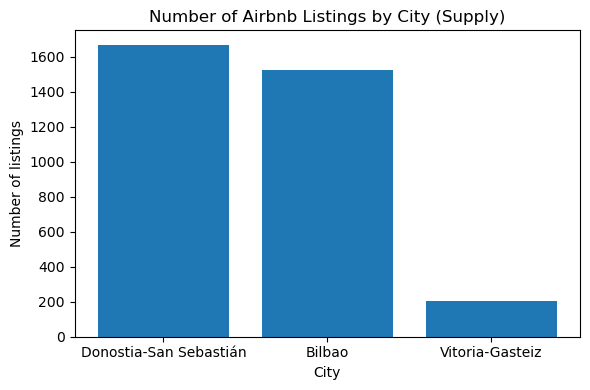

In [68]:
#8 PLOTS_ Supply/Demand/Revenue/Supply vs Demand for 3 capital cities
# SUPPLY PLOT

plt.figure(figsize=(6,4))
plt.bar(supply_capital['city'], supply_capital['num_listings'])
plt.title('Number of Airbnb Listings by City (Supply)')
plt.ylabel('Number of listings')
plt.xlabel('City')
plt.tight_layout()
plt.show()


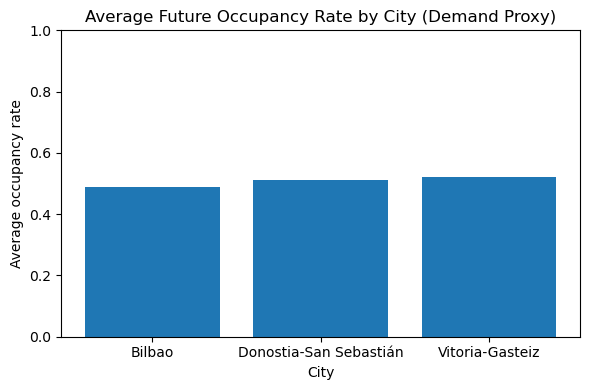

In [69]:
#DEMAND PLOT (occupancy PROXY)
plt.figure(figsize=(6,4))
plt.bar(demand_capital['city'], demand_capital['avg_occupancy_rate'])
plt.title('Average Future Occupancy Rate by City (Demand Proxy)')
plt.ylabel('Average occupancy rate')
plt.xlabel('City')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


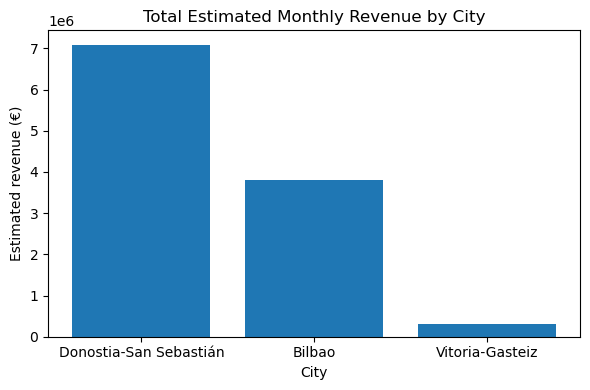

In [86]:
#REVENUE PLOT
plt.figure(figsize=(6,4))
plt.bar(
    revenue_capital['city'],
    revenue_capital['total_revenue'].str.replace('[€,]', '', regex=True).astype(float)
)
plt.title('Total Estimated Monthly Revenue by City')
plt.ylabel('Estimated revenue (€)')
plt.xlabel('City')
plt.tight_layout()
plt.show()


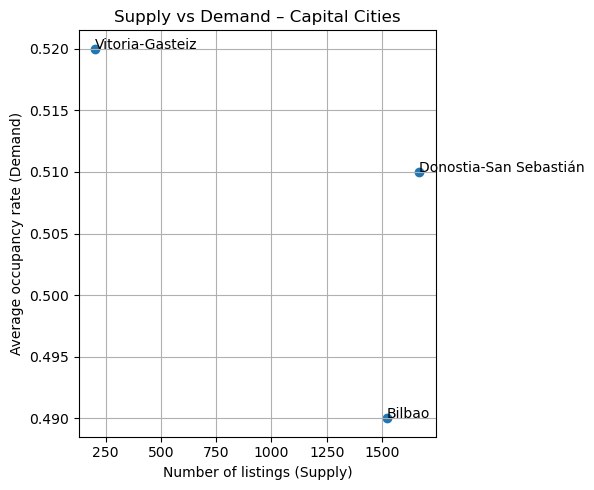

In [72]:
#Supply vs Demand PLOT
market_capitals = (
    supply_capital
    .merge(demand_capital, on='city')
)

plt.figure(figsize=(6,5))
plt.scatter(
    market_capitals['num_listings'],
    market_capitals['avg_occupancy_rate']
)

for i, row in market_capitals.iterrows():
    plt.text(
        row['num_listings'],
        row['avg_occupancy_rate'],
        row['city'],
        fontsize=10
    )

plt.xlabel('Number of listings (Supply)')
plt.ylabel('Average occupancy rate (Demand)')
plt.title('Supply vs Demand – Capital Cities')
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
#9 SAN SEBASTIAN INTERNAL ANALYSIS
# Because the dataset lacks official neighborhood boundaries, we create a spatial proxy by splitting the city
# into four zones using median latitude (North/South) and longitude (East/West).
#The dataset does not provide official neighbourhood-level information within San Sebastián.
#A<s a result, the analysis focuses on city-level housing pressure, treating San Sebastián as a single urban unit.
#This approach is consistent with the available data and avoids introducing artificial geographic assumptions.
#Latitude measures the north–south position of a listing, while longitude measures the east–west position.
#Due to the absence of official neighbourhood-level data, the median latitude and longitude of San Sebastián are used to divide the city into four geographic zones.
#This approach provides a spatial proxy to analyse internal concentration of Airbnb activity.

In [74]:
#Restrict the dataset to listings located in San Sebastián
san_sebastian = master[master['city'] == 'Donostia-San Sebastián'].copy()
san_sebastian.shape
san_sebastian.describe()

,listing_id,host_id,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms_clean,occupancy_rate,num_reviews,last_review_date,avg_min_nights,est_monthly_revenue
count,1.668000e+03,1.668000e+03,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,...,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1492,1668.000000,1668.000000
mean,4.653799e+17,1.767518e+08,43.317073,-1.981695,3.896283,1.992206,2.863909,294.176259,4.044365,663.256595,...,22.549760,1.405276,0.002398,1.450917,1.535072,0.505631,77.824341,2025-02-23 10:49:32.654155520,5.599021,4246.294802
min,1.320680e+05,4.387510e+05,43.257557,-2.078010,1.000000,0.000000,0.000000,29.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017-08-26 00:00:00,1.000000,0.000000
25%,2.746671e+07,2.132060e+07,43.313997,-1.985120,2.000000,1.000000,1.000000,150.000000,1.000000,365.000000,...,1.000000,0.000000,0.000000,0.330000,1.000000,0.232877,8.000000,2025-04-21 00:00:00,1.934247,1515.821918
50%,5.078993e+07,1.091369e+08,43.318330,-1.981408,4.000000,2.000000,3.000000,230.000000,2.000000,365.000000,...,2.000000,0.000000,0.000000,0.940000,1.000000,0.504110,37.000000,2025-06-08 00:00:00,2.257534,2992.191781
75%,9.603655e+17,2.848276e+08,43.323014,-1.974402,5.000000,3.000000,4.000000,363.000000,2.000000,1125.000000,...,18.000000,1.000000,0.000000,2.092500,2.000000,0.769863,95.000000,2025-06-20 00:00:00,3.028767,5628.780822
max,1.451400e+18,7.002687e+08,43.328870,-1.919395,15.000000,10.000000,16.000000,3427.000000,60.000000,1500.000000,...,145.000000,32.000000,2.000000,22.060000,6.500000,1.000000,1262.000000,2025-07-02 00:00:00,199.150685,68727.780822
std,5.400191e+17,1.850063e+08,0.008149,0.014233,1.760231,1.019574,1.696552,253.084829,7.627607,449.481237,...,42.646078,4.708034,0.069234,1.656165,0.752998,0.295224,110.102432,NaN,10.095726,4413.004781


In [75]:
#We use the median latitude/longitude as robust cut-off points to split the city.
lat_median = san_sebastian['latitude'].median()
lon_median = san_sebastian['longitude'].median()

print("lat_median:", lat_median)
print("lon_median:", lon_median)


lat_median: 43.31832996424853
lon_median: -1.981408321897688


In [76]:
#Latitude defines North vs South; longitude defines East vs West.
san_sebastian['north_south'] = np.where(
    san_sebastian['latitude'] >= lat_median, 'North', 'South'
)

san_sebastian['east_west'] = np.where(
    san_sebastian['longitude'] >= lon_median, 'East', 'West'
)


In [77]:
#Combining both dimensions creates four internal geographic zones.
san_sebastian['zone'] = san_sebastian['north_south'] + '-' + san_sebastian['east_west']
san_sebastian['zone'].value_counts()


zone
North-East    528
South-West    528
North-West    306
South-East    306
Name: count, dtype: int64

In [78]:
#Supply is measured as the number of listings
#Demand is approximated by average occupancy rate
#Economic impact is proxied by estimated monthly revenue
zone_kpis = (
    san_sebastian.groupby('zone')
    .agg(
        num_listings=('listing_id', 'count'),
        avg_occupancy_rate=('occupancy_rate', 'mean'),
        total_est_monthly_revenue=('est_monthly_revenue', 'sum'),
        avg_price=('price', 'mean')
    )
    .reset_index()
)

zone_kpis[['avg_occupancy_rate','total_est_monthly_revenue','avg_price']] = \
    zone_kpis[['avg_occupancy_rate','total_est_monthly_revenue','avg_price']].round(2)

zone_kpis


,zone,num_listings,avg_occupancy_rate,total_est_monthly_revenue,avg_price
0,North-East,528,0.49,2131980.72,285.51
1,North-West,306,0.50,1429644.08,323.88
2,South-East,306,0.51,1098326.63,245.72
3,South-West,528,0.52,2422868.30,313.72


In [79]:
#Format for presentation
zone_kpis['avg_occupancy_rate'] = (zone_kpis['avg_occupancy_rate'] * 100).round(1).astype(str) + '%'
zone_kpis['total_est_monthly_revenue'] = zone_kpis['total_est_monthly_revenue'].apply(lambda x: f"€{x:,.2f}")
zone_kpis['avg_price'] = zone_kpis['avg_price'].apply(lambda x: f"€{x:,.2f}")

zone_kpis


,zone,num_listings,avg_occupancy_rate,total_est_monthly_revenue,avg_price
0,North-East,528,49.0%,"€2,131,980.72",€285.51
1,North-West,306,50.0%,"€1,429,644.08",€323.88
2,South-East,306,51.0%,"€1,098,326.63",€245.72
3,South-West,528,52.0%,"€2,422,868.30",€313.72


In [80]:
#10 FOLIM HEATMAP
!pip install folium


In [96]:
#Heatmap: filter the dataset to listings located in San Sebastián and keep valid coordinates.
import folium
from folium.plugins import HeatMap

san_sebastian = master[master['city'] == 'Donostia-San Sebastián'].copy()

san_sebastian[['latitude','longitude']].dropna().shape


(1668, 2)

In [97]:
# Map center (average coordinates)
center = [san_sebastian['latitude'].mean(), san_sebastian['longitude'].mean()]

m = folium.Map(location=center, zoom_start=12)

# Heatmap data: [lat, lon]
heat_data = san_sebastian[['latitude', 'longitude']].dropna().values.tolist()

HeatMap(
    heat_data,
    radius=12,      # bigger radius = smoother heat
    blur=15
).add_to(m)

m


In [98]:
m.save("san_sebastian_heatmap_listings.html")


In [99]:
#11 EXTERNAL INDOCATOR (Basque Government) from indicator.csv file
# lets link with the data of the basque government of housing demand

# Load external indicator dataset (Basque Government – housing / sustainability indicators)
#https://opendata.euskadi.eus/catalogo/-/indicadores-municipales-de-sostenibilidad-solicitudes-de-vivienda-que-constan-en-etxebide-x2030-habitantes/
import pandas as pd

indicator_raw = pd.read_csv(
    "indicator.csv",
    encoding="latin1",
    sep=";",        # <-- clave
    header=None,
    engine="python" # <-- más tolerante
)



# Use row 3 as header
indicator_raw.columns = indicator_raw.iloc[3]
indicator = indicator_raw.iloc[4:].reset_index(drop=True)
indicator = indicator.rename(columns={indicator.columns[0]: "Entidad"})
indicator.head(10)







3,Entidad,NaN,2023,2022,2021,2020,2019,2018,2017,2016,...,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005
0,Araba/Álava,NaN,"45,48","37,30","36,91","35,33","32,37","29,80","27,56","22,75",...,"24,04","30,83","28,93","37,92","37,70","45,09","53,05","57,82","59,66","61,13"
1,Bizkaia,NaN,"69,39","52,36","55,16","54,52","49,71","45,26","43,63","37,45",...,"36,69","42,55","40,66","40,56","39,85","41,92","38,33","37,74","37,07","35,16"
2,CAE,NaN,"62,66","50,71","52,55","51,59","46,32","42,47","40,32","34,10",...,"33,74","40,56","38,50","40,70","40,76","44,03","43,33","44,08","43,64","41,13"
3,Gipuzkoa,NaN,"59,93","54,29","55,60","54,38","47,32","43,81","40,86","33,89",...,"33,40","41,74","39,31","42,18","43,62","47,02","47,22","48,41","47,40","42,16"
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Detalle por comarcas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Código comarca,Comarca,2023,2022,2021,2020,2019,2018,2017,2016,...,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005
7,01100,Arabako Ibarrak / Valles Alaveses,"17,90","16,01","15,64","40,69","14,29","13,94","13,00","10,61",...,"9,87","11,30","5,67","3,32","2,35","2,37","1,75","2,30","3,06","3,87"
8,01200,Arabako Lautada / Llanada Alavesa,"49,46","40,44","40,11","1,12","34,98","31,86","29,47","24,65",...,"25,84","33,29","31,41","41,88","40,83","49,83","59,23","64,92","67,58","69,57"
9,01300,Arabako Mendialdea / Montaña Alavesa,"12,38","9,98","10,18","16,04","6,29","9,64","9,96","7,31",...,"7,64","12,41","7,57","7,48","7,83","8,12","6,88","6,62","5,71","5,09"


In [100]:
import pandas as pd
import matplotlib.pyplot as plt


In [101]:
#Indicator for Gipuzkoa, Bizkaia, Araba
territories = ["Gipuzkoa", "Bizkaia", "Araba/Álava"]

indicator_territories = indicator[indicator["Entidad"].isin(territories)].copy()
indicator_territories


3,Entidad,NaN,2023,2022,2021,2020,2019,2018,2017,2016,...,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005
0,Araba/Álava,NaN,"45,48","37,30","36,91","35,33","32,37","29,80","27,56","22,75",...,"24,04","30,83","28,93","37,92","37,70","45,09","53,05","57,82","59,66","61,13"
1,Bizkaia,NaN,"69,39","52,36","55,16","54,52","49,71","45,26","43,63","37,45",...,"36,69","42,55","40,66","40,56","39,85","41,92","38,33","37,74","37,07","35,16"
3,Gipuzkoa,NaN,"59,93","54,29","55,60","54,38","47,32","43,81","40,86","33,89",...,"33,40","41,74","39,31","42,18","43,62","47,02","47,22","48,41","47,40","42,16"


In [102]:
# Últimos 10 años (de más antiguo a más reciente)
years = ["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]


In [103]:

plot_data = indicator_territories.set_index("Entidad")[years].copy()

# Convert values like "45,48" -> "45.48" and then to numeric
plot_data = plot_data.apply(lambda col: pd.to_numeric(
    col.astype(str).str.replace(",", ".", regex=False),
    errors="coerce"
))


In [104]:
plot_data.isna().sum()


3
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
dtype: int64

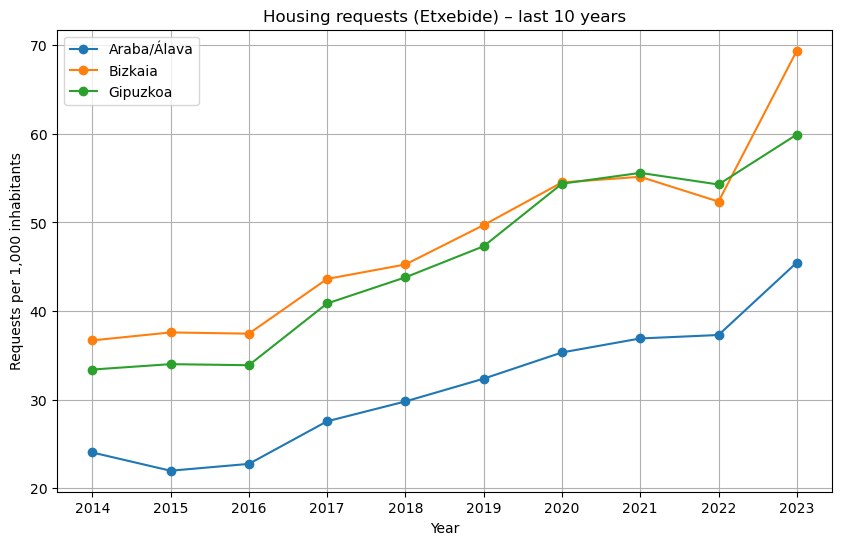

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for territory in plot_data.index:
    plt.plot(years, plot_data.loc[territory], marker="o", label=territory)

plt.title("Housing requests (Etxebide) – last 10 years")
plt.xlabel("Year")
plt.ylabel("Requests per 1,000 inhabitants")
plt.legend()
plt.grid(True)
plt.show()


In [106]:
#And now the same but in san sebastian

In [107]:
import pandas as pd

indicator_raw = pd.read_csv(
    "indicator.csv",
    encoding="latin1",
    header=None,
    sep=";"
)


In [108]:
start_row = indicator_raw[indicator_raw[0] == "Código comarca"].index[0]

comarcas = indicator_raw.iloc[start_row:].reset_index(drop=True)
comarcas.head(10)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Código comarca,Comarca,2023,2022,2021,2020,2019,2018,2017,2016,...,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005
1,01100,Arabako Ibarrak / Valles Alaveses,"17,90","16,01","15,64","40,69","14,29","13,94","13,00","10,61",...,"9,87","11,30","5,67","3,32","2,35","2,37","1,75","2,30","3,06","3,87"
2,01200,Arabako Lautada / Llanada Alavesa,"49,46","40,44","40,11","1,12","34,98","31,86","29,47","24,65",...,"25,84","33,29","31,41","41,88","40,83","49,83","59,23","64,92","67,58","69,57"
3,01300,Arabako Mendialdea / Montaña Alavesa,"12,38","9,98","10,18","16,04","6,29","9,64","9,96","7,31",...,"7,64","12,41","7,57","7,48","7,83","8,12","6,88","6,62","5,71","5,09"
4,48100,Arratia Nerbioi / Arratia-Nervión,"33,25","23,49","25,35","261,97","22,44","22,69","22,31","17,40",...,"17,45","22,06","18,88","18,38","17,53","19,40","20,72","21,38","21,30","18,33"
5,20200,Bidasoa Beherea / Bajo Bidasoa,"56,89","52,63","54,94","29,81","47,61","45,32","40,22","31,30",...,"28,95","32,48","30,38","29,79","28,46","28,28","28,54","28,01","25,63","20,59"
6,48200,Bilbo Handia / Gran Bilbao,"77,39","58,67","61,44","12,93","55,42","50,30","48,24","41,39",...,"39,99","46,68","45,17","44,40","43,53","45,42","41,03","40,26","39,32","37,27"
7,20100,Deba Beherea / Bajo Deba,"37,19","33,61","34,58","74,32","31,02","30,13","28,86","22,56",...,"20,68","29,17","26,99","30,15","33,21","35,21","34,83","35,25","35,12","33,58"
8,20300,Debagoiena / Alto Deba,"30,31","25,98","27,78","19,72","23,23","20,90","18,95","16,11",...,"17,69","28,37","25,53","30,31","32,38","38,15","45,15","49,14","48,23","44,66"
9,20400,Donostialdea / Donostia-San Sebastián,"76,72","70,23","71,61","4,91","60,44","54,63","52,50","43,99",...,"44,59","55,28","52,54","56,40","58,09","62,13","60,36","61,98","62,80","56,39"


In [109]:
comarcas.columns = comarcas.iloc[0]
comarcas = comarcas.iloc[1:].reset_index(drop=True)


In [110]:
print(comarcas.columns.tolist())



['Código comarca', 'Comarca', '2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005']


In [111]:
target_comarcas = [
    "Bilbao", "Donostia / San Sebastián","Vitoria-Gasteiz"
]


In [112]:
sel = comarcas[comarcas["Comarca"].isin(target_comarcas)].copy()
sel


,Código comarca,Comarca,2023,2022,2021,2020,2019,2018,2017,2016,...,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005
93,48020,Bilbao,"79,03","60,03","62,18","15,33","57,29","52,76","51,59","44,88",...,"42,88","53,95","53,29","51,65","49,70","50,37","44,43","43,75","42,32","40,18"
99,20069,Donostia / San Sebastián,"75,28","69,53","71,46","0,01","61,82","55,42","53,14","44,68",...,"45,24","60,47","57,85","60,87","62,44","66,92","64,19","65,62","66,83","61,21"
252,01059,Vitoria-Gasteiz,"50,66","41,60","41,37","0,04","36,16","32,95","30,47","25,47",...,"26,68","34,45","32,86","43,80","42,78","52,31","62,16","68,16","70,86","72,65"


In [113]:
#select last 10 years
years = [str(y) for y in range(2023, 2013, -1)]


In [114]:
for col in years:
    sel[col] = (
        sel[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )


In [115]:
sel = sel.set_index("Comarca")
df_plot = sel[years].T
df_plot.index = df_plot.index.astype(int)


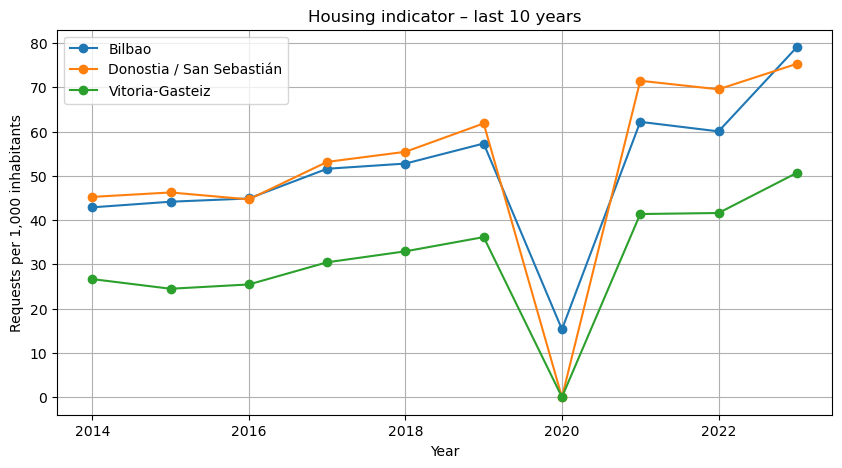

In [116]:
import matplotlib.pyplot as plt

# Crear gráfico
plt.figure(figsize=(10,5))

for comarca in df_plot.columns:
    plt.plot(df_plot.index, df_plot[comarca], marker="o", label=comarca)

plt.title("Housing indicator – last 10 years")
plt.xlabel("Year")

# Aquí pones lo que tú quieras que aparezca en el eje Y:
plt.ylabel("Requests per 1,000 inhabitants")  # o "Value per 1,000 inhabitants"

plt.grid(True)
plt.legend()
plt.show()
